CSE 158/258 - Recommender Sys & Web Mining - FA24
# Assignment 2 Report

Andrew Choi (A69033628), Chanbin Na (AA18087468), Jonghee Chun (A69033997), Kenny Hwang (A99021639)

[Github Repo](https://github.com/cjychoi/cse258-fa24/tree/main)

## 1. Exploratory Dataset Analysis

**Dataset: Food.com Recipes and Interactions**\
Source: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions

This dataset includes over 180K+ recipes and 700K+ recipe reviews spanning 18 years of user interactions and uploads on Food.com. For our analysis, we will utilize two files: **RAW_interactions.csv** and **RAW_recipes.csv**. We selected this dataset due to its rich and diverse information. Some of the interesting values included: 
```
- user_id: Unique user ID values
- recipe_id: Unique recipe ID values
- rating: Rating given from user (0~5 scale)
- review: Review of the recipe (text)
- minutes: Minutes to prepare the recipe
- tags: Food.com tags for each recipes
- nutrition: Nutrition information (calories, total fat, sugar, sodium, protein, saturated fat)
- n_steps: Number of steps in recipe
- ingredients: List of ingredient names
- n_ingredients: Number of ingredients
- description: User-provided description
```

From the first glance, a lot of values seemed to have interesting correlations to each other, such as 'minutes', 'n_steps', and 'n_ingredients' may affect the user's 'rating' because it could be a burden to cook a complicated recipe and may lead to a lower rating.

We have summarized the properites of the dataset and was able to retrieve the following results:\
<img src="img/data_summary.png" width="280">
<img src="img/data_ratings.png" width="400">
<img src="img/data_ingredients.png" width="400">
<img src="img/data_recipe_sub.png" width="404">

### Analysis
- **Dataset Characteristics:**
    - The dataset is extensive, with over 230,000 recipes and 1.1 million interactions, making it robust for machine learning tasks like recommendation systems or rating predictions.
    - The average number of ingredients per recipe (around 9.55) suggests that most recipes are relatively simple, with a manageable number of ingredients.

- **Rating Distribution:**
    - The ratings are heavily skewed towards the highest score (5), which might indicate a bias in user reviews or a tendency for users to rate recipes they liked rather than disliked.
    - The small number of ratings below 4 suggests that poorly received recipes may either not be reviewed often or that users prefer not to leave negative feedback.

- **Ingredients Popularity:**
    - Common ingredients like salt, butter, sugar, and onion dominate the dataset, reflecting their foundational role in a wide variety of recipes.
    - These ingredients are versatile and likely to appear in both simple and complex recipes, which might impact model predictions for recipe similarity or ingredient importance.

- **Temporal Trends:**
    - Recipe submissions peaked around 2007, reflecting either a surge in platform popularity or increased engagement during that period.
    - The sharp decline after 2007 might be due to changes in platform usage, competition from other recipe-sharing platforms, or a reduction in user engagement.

- **Insights for Predictive Modeling:**
    - The skewed rating distribution could pose challenges for regression models, requiring careful handling, such as rebalancing or weighted loss functions, to mitigate bias.
    - The dominance of certain ingredients might mean they have less predictive power for ratings, as they are present in a large proportion of recipes.
    - Temporal trends could be factored into models to study how recipe popularity or user engagement changed over time, which might also correlate with rating patterns.


## 2. Predictive Task and Evaluation

### Predictive Task 1

The goal is to predict the rating. As a first step, we analyzed whether any features of the recipes show a correlation with the rating. We examined all the numerical features—`minutes`, `n_steps`, and `n_ingredients`—to determine if they have any correlation with the rating. 

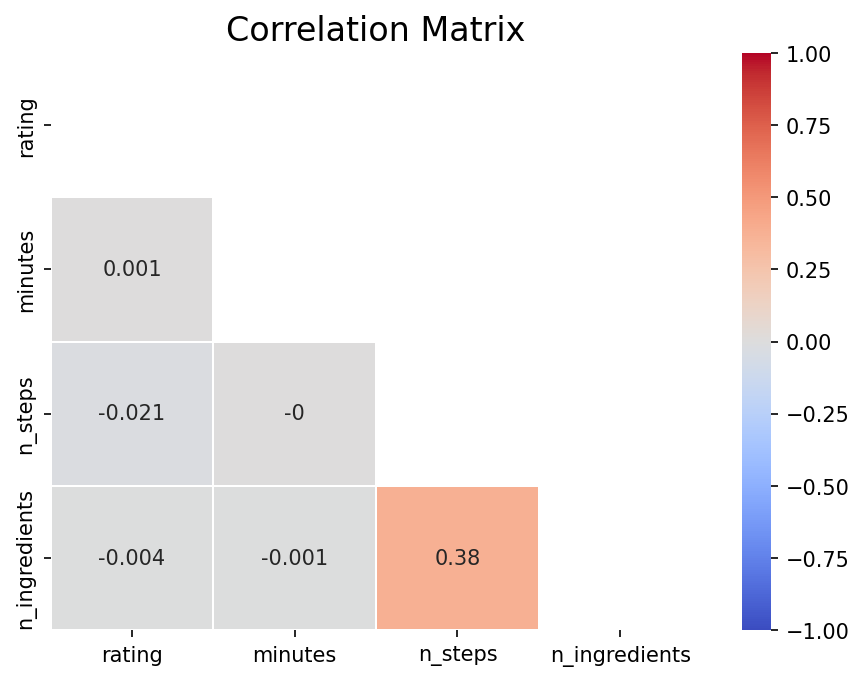

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the datasets
recipes = pd.read_csv('RAW_recipes_textProc_VecTag(th=5)_VecIng(th=500).csv')
interactions = pd.read_csv('RAW_interactions_textProc.csv')

# Rename and merge datasets on 'recipe_id'
recipes = recipes.rename(columns={'id': 'recipe_id'})
data = interactions.merge(recipes, on='recipe_id')

# Encode 'user_id' using LabelEncoder
user_encoder = LabelEncoder()
data['user_id'] = user_encoder.fit_transform(data['user_id'])

# Prepare the features for correlation matrix
corr_columns = [
    'rating', 'minutes', 'n_steps', 'n_ingredients'
]
data_filtered = data[corr_columns]
data_filtered = data_filtered.dropna()  # Drop rows with missing values

# Calculate correlation matrix
corr_matrix = data_filtered.corr().round(3)

# Plot the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(7, 5), dpi=150)
sns.heatmap(corr_matrix, vmin=-1, vmax=1, linewidths=.2, center=0.0, mask=mask, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In addition to calculating the correlation, we also determined the coefficients to quantify the relationship between these features and the rating.

```txt
Feature: minutes 
  Coefficient: 0.000 
  Intercept: 4.411 
  R^2 Score: 0.000 

Feature: n_steps 
  Coefficient: -0.005 
  Intercept: 4.455 
  R^2 Score: 0.000 

Feature: n_ingredients 
  Coefficient: -0.001 
  Intercept: 4.422 
  R^2 Score: 0.000 
```

The analysis shows that `minutes`, `n_steps`, and `n_ingredients` have negligible correlations with `rating`, and their regression models with R² scores of 0.000 explain no variance. While `n_steps` and `n_ingredients` moderately correlate (0.38), these features are insufficient for predicting `rating`. 

As none of the recipe features proved useful, we shifted focus to predicting rating using `review text`, as it is the only feature that shows a meaningful correlation with `rating`.

In [2]:
# Feature: n_ingredients
X_n_ingredients = data[['n_ingredients']]
model_n_ingredients = LinearRegression()
model_n_ingredients.fit(X_n_ingredients, y)

print("Feature: n_ingredients")
print("  Coefficient:", model_n_ingredients.coef_[0])
print("  Intercept:", model_n_ingredients.intercept_)
print("  R^2 Score:", r2_score(y, model_n_ingredients.predict(X_n_ingredients)))

NameError: name 'data' is not defined



### Predictive Task 2
The task is to recommend recipes similar to a given recipe based on their ingredient similarity. The **Jaccard Similarity** is used to calculate the similarity between the sets of ingredients in recipes. The results provide the top 5 similar recipes for a given target recipe.

### Data Processing
- Input Features: The ingredients of each recipe are used as input features. These are stored in the ingredients column in the dataset.
- Preprocessing: The ingredients column is converted into a set for each recipe, enabling the computation of Jaccard Similarity.
- Mapping: Recipe IDs are mapped to their respective ingredient sets using the id column for identification

### Model
- Jaccard Similarity:
    - Measures the similarity between two sets as the ratio of the intersection size to the union size.
​
- Baseline:
    - The baseline for this task is a random recommendation, which serves as a benchmark to compare the performance of the Jaccard-based similarity recommendation system.

In [1]:
# Create a mapping of recipe IDs to their ingredient sets
recipe_ingredient_sets = recipes.set_index("id")["ingredients"].apply(set)

# Define a function to compute Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

# Recommend recipes based on Jaccard similarity
def recommend_recipes(target_recipe_id, recipes, recipe_ingredient_sets, num_recommendations=5):
    target_ingredients = recipe_ingredient_sets[target_recipe_id]
    similarities = {}

    # Calculate Jaccard similarity with all other recipes
    for recipe_id, ingredients in recipe_ingredient_sets.items():
        if recipe_id != target_recipe_id:  # Skip the target recipe itself
            similarity = jaccard_similarity(target_ingredients, ingredients)
            similarities[recipe_id] = similarity

    # Sort recipes by similarity and get top recommendations
    top_recommendations = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:num_recommendations]

    # Fetch recipe details
    recommended_recipes = recipes.loc[recipes["id"].isin([rec[0] for rec in top_recommendations])].copy()
    recommended_recipes["Jaccard Similarity"] = [rec[1] for rec in top_recommendations]

    # Display results
    print(f"\nTop {num_recommendations} Recipes Similar to '{recipes.loc[recipes['id'] == target_recipe_id, 'name'].values[0]}':\n")
    for _, row in recommended_recipes.iterrows():
        print(f"Recipe: {row['name']} (ID: {row['id']})")
        print(f"Ingredients: {', '.join(row['ingredients'])}")
        print(f"Jaccard Similarity: {row['Jaccard Similarity']:.2f}\n")

    return recommended_recipes

# Example: Recommend recipes similar to recipe_id=137739
recommendations = recommend_recipes(137739, recipes, recipe_ingredient_sets, num_recommendations=5)

NameError: name 'recipes' is not defined

### Results
```
Top 5 Recipes Similar to 'arriba   baked winter squash mexican style':

Recipe: berber spice roasted chickpeas (ID: 514675)\
Ingredients: dried garbanzo beans, salt, olive oil, mixed spice\
Jaccard Similarity: 0.38

Recipe: ed s homemade microwave buttery popcorn (ID: 408958)\
Ingredients: popcorn, butter, olive oil, salt\
Jaccard Similarity: 0.38

Recipe: honey roasted peanuts (ID: 147856)\
Ingredients: peanuts, butter, honey, salt\
Jaccard Similarity: 0.38

Recipe: julia child method of preparing garlic (ID: 104441)\
Ingredients: garlic, butter, olive oil, salt\
Jaccard Similarity: 0.38

Recipe: potatoes rissole (ID: 72347)\
Ingredients: russet potatoes, salt, butter, olive oil\
Jaccard Similarity: 0.38
```

**Ingredient Overlap:**
- Many of the recommended recipes have overlapping ingredients like salt, olive oil, and butter, which are common foundational ingredients.
- This high overlap in foundational ingredients likely drives the similarity scores.

**Limitations:**
- The recommendations are heavily influenced by the most commonly occurring ingredients (e.g., salt, olive oil), which could reduce diversity in recommendations.
- Recipes with unique or specialized ingredients may not be well-represented due to their rarity in the dataset.

**Potential Enhancements:**
- Weighting ingredient importance could improve the diversity of recommendations by prioritizing unique ingredients over ubiquitous ones.
- Incorporating additional features such as tags, preparation steps, or user ratings could refine the recommendation system.

### Evaluation of Predictive Task

**Evaluation:**
- The recommendations are evaluated qualitatively by examining the relevance of the similar recipes.
- Quantitative evaluation can include precision and recall by comparing recommendations to user interaction data (if available).

**Baseline:**
- Random recipe recommendations serve as the baseline for comparison. The Jaccard Similarity-based system outperforms this by providing contextually similar recipes.

**Validity:**
- The approach is valid as it directly leverages shared ingredient sets, which align with user expectations for similar recipes.

## 3. Model Description

### Proposed Model:

Description of the model(s) used and why they were chosen.\
Explanation of how the model was implemented and optimized.

### Challenges

Major challenge that we had was determining the correlation between the features and the ratings.

## 4. Related Literature

## 5. Results and Conclusions

## 6. References

**Food.com Recipes and Interactions (Kaggle)**\
Crawled data from Food.com (GeniusKitchen) online recipe aggregator\
https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions?select=PP_recipes.csv


**Generating Personalized Recipes from Historical User Preferences**\
Bodhisattwa Prasad Majumder*, Shuyang Li*, Jianmo Ni, Julian McAuley
EMNLP, 2019\
https://www.aclweb.org/anthology/D19-1613/\
https://aclanthology.org/D19-1613.pdf
